# Análise exploratória de vendas e-commerce

Este notebook apresenta uma análise exploratória dos dados de vendas, com foco em KPIs, comportamento de clientes e produtos.

## 1. Importação das bibliotecas

In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import timedelta

## 2. Setup de diretórios e caminho dos dados

In [24]:
os.makedirs("imagens", exist_ok=True)
os.makedirs("data", exist_ok=True)
DATA_PATH = "data/data.csv"

## 3. Configurações de visualização

In [25]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

## 4. Carregamento e limpeza dos dados

Carregamos o dataset, removemos duplicatas e registros sem cliente, e criamos a coluna de valor total da compra.

In [26]:
df = pd.read_csv(DATA_PATH, encoding="ISO-8859-1")
df = df.dropna(subset=["CustomerID"])
df = df.drop_duplicates()
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df = df.reset_index(drop=True)
df["TotalValue"] = df["Quantity"] * df["UnitPrice"]

### Visualização inicial dos dados

In [ ]:
display(df.head())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalValue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## 5. Tratamento de devoluções/cancelamentos

Identificamos notas de devolução/cancelamento e calculamos receita bruta, valor devolvido e receita líquida.

In [33]:
df["IsCancel"] = df["InvoiceNo"].astype(str).str.startswith("C")
receita_bruta = df.loc[~df["IsCancel"], "TotalValue"].sum()
valor_devolvido = -df.loc[df["IsCancel"], "TotalValue"].sum()
receita_liquida = receita_bruta - valor_devolvido

## 6. KPIs principais

Resumo dos principais indicadores do negócio.

In [34]:
num_pedidos = df.loc[~df["IsCancel"], "InvoiceNo"].nunique()
num_clientes = df["CustomerID"].nunique()
ticket_medio = receita_liquida / num_pedidos

kpi_board = pd.DataFrame({
    "Métrica": [
        "Receita Bruta (£)", "Valor Devolvido (£)", "Receita Líquida (£)",
        "Nº Pedidos", "Nº Clientes", "Ticket Médio (£)"
    ],
    "Valor": [
        receita_bruta, valor_devolvido, receita_liquida,
        num_pedidos, num_clientes, ticket_medio
    ]
})
kpi_board["Valor"] = kpi_board["Valor"].apply(lambda x: f"{x:,.2f}")
display(kpi_board)

,Métrica,Valor
0,Receita Bruta (£),"8,887,208.89"
1,Valor Devolvido (£),"608,689.47"
2,Receita Líquida (£),"8,278,519.42"
3,Nº Pedidos,"18,536.00"
4,Nº Clientes,"4,372.00"
5,Ticket Médio (£),446.62


## 7. Análise RFM

A análise RFM (Recência, Frequência, Valor Monetário) permite identificar diferentes perfis de clientes.

In [35]:
snapshot_date = df["InvoiceDate"].max() + timedelta(days=1)
rfm = (
    df.groupby("CustomerID")
      .agg(
          Recency=("InvoiceDate", lambda x: (snapshot_date - x.max()).days),
          Frequency=("InvoiceNo", "nunique"),
          Monetary=("TotalValue", "sum")
      )
      .reset_index()
)
display(rfm.head())

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


### Gráfico: Relação entre frequência e valor monetário

Clientes mais frequentes tendem a gerar maior valor monetário. A cor indica a recência (quanto menor, mais recente).

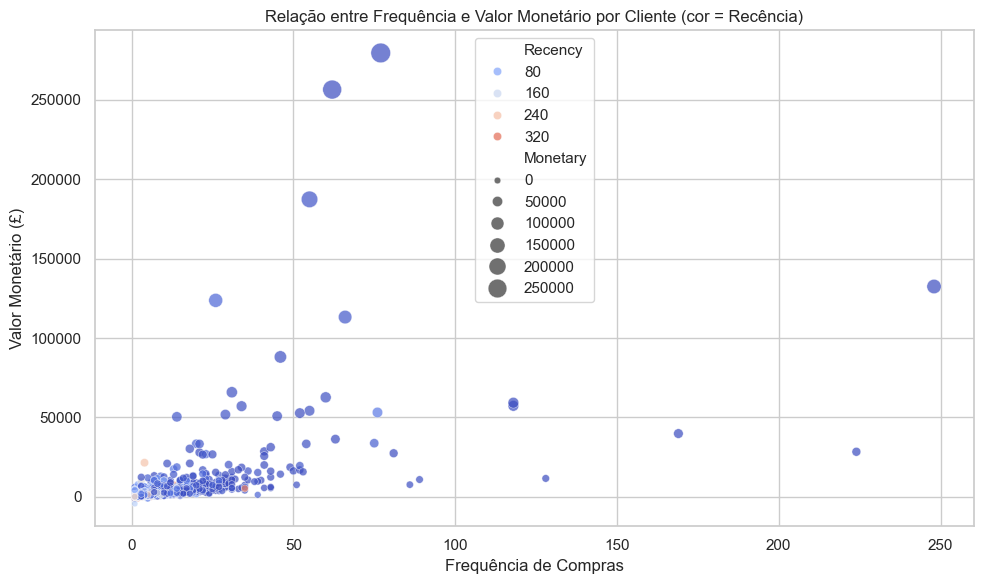

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=rfm,
    x="Frequency",
    y="Monetary",
    hue="Recency",
    palette="coolwarm",
    size="Monetary",
    sizes=(20, 200),
    alpha=0.7
)
plt.title("Relação entre Frequência e Valor Monetário por Cliente (cor = Recência)")
plt.xlabel("Frequência de Compras")
plt.ylabel("Valor Monetário (£)")
plt.tight_layout()
plt.savefig("imagens/rfm_scatter.png", dpi=300)
plt.show()


## 8. Receita por dia da semana e hora

O heatmap abaixo mostra em quais dias e horários a loja tem maior receita.

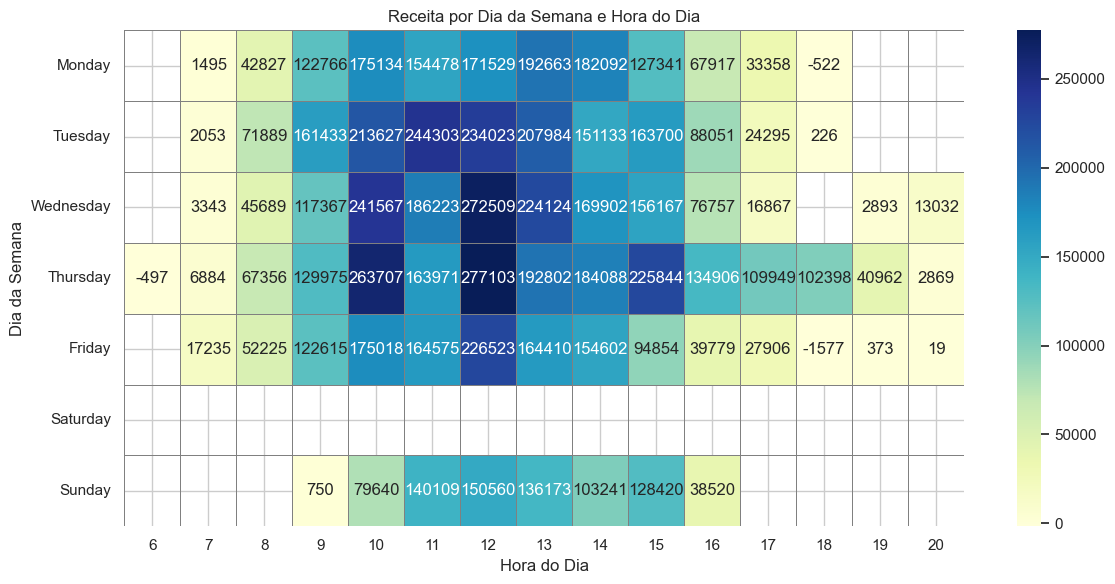

In [36]:
df["DiaSemana"] = df["InvoiceDate"].dt.day_name()
df["Hora"] = df["InvoiceDate"].dt.hour

pivot_heatmap = df.pivot_table(
    values="TotalValue",
    index="DiaSemana",
    columns="Hora",
    aggfunc="sum"
)

dias_ordem = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
pivot_heatmap = pivot_heatmap.reindex(dias_ordem)

plt.figure(figsize=(12,6))
sns.heatmap(
    pivot_heatmap,
    cmap="YlGnBu",
    linewidths=.5,
    linecolor="gray",
    annot=True,
    fmt=".0f"
)
plt.title("Receita por Dia da Semana e Hora do Dia")
plt.xlabel("Hora do Dia")
plt.ylabel("Dia da Semana")
plt.tight_layout()
plt.savefig("imagens/heatmap_dia_hora.png", dpi=300)
plt.show()

## 9. Cálculos e Gráficos

### 1. Ticket Médio

O ticket médio mostra quanto, em média, cada cliente gasta por compra. Esse indicador é importante para entender o valor médio das transações.

In [37]:
ticket_medio = df.groupby("CustomerID")["TotalValue"].mean().mean()
print(f"Ticket médio: £{ticket_medio:,.2f}")

Ticket médio: £28.87


### 2. Top 10 produtos mais vendidos

Visualizamos os produtos mais vendidos em quantidade. Isso ajuda a identificar os itens de maior saída e preferências dos clientes.

C:\Users\Pedro\AppData\Local\Temp\ipykernel_19544\4187904619.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_produtos.values, y=top_produtos.index, palette="crest")


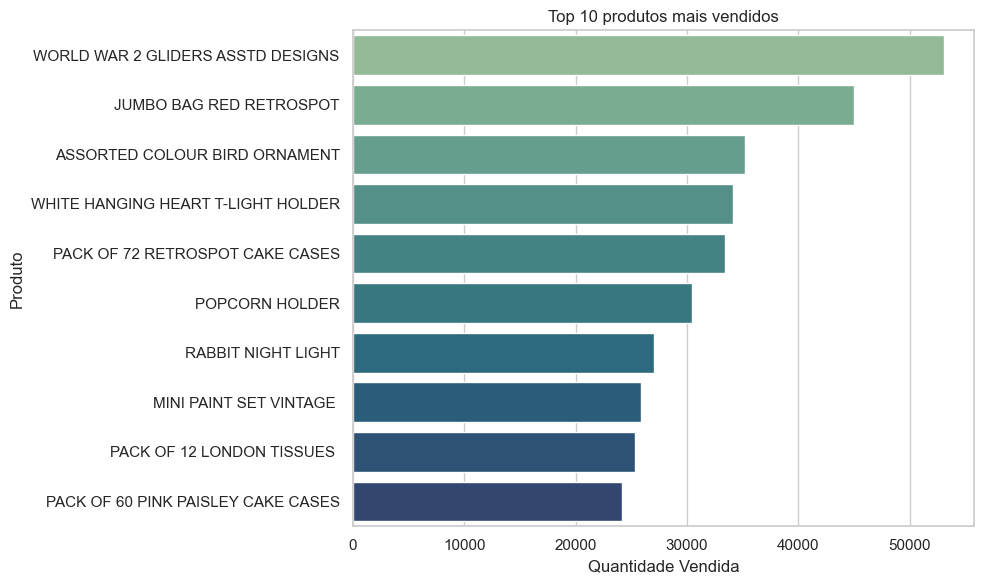

In [38]:
top_produtos = df.groupby("Description")["Quantity"].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_produtos.values, y=top_produtos.index, palette="crest")
plt.title("Top 10 produtos mais vendidos")
plt.xlabel("Quantidade Vendida")
plt.ylabel("Produto")
plt.tight_layout()
plt.show()

### 3. Top 10 países por valor de vendas

Aqui analisamos os países que mais geram receita para a loja, auxiliando em estratégias de expansão e foco comercial.

C:\Users\Pedro\AppData\Local\Temp\ipykernel_19544\1927011496.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vendas_por_pais.values, y=vendas_por_pais.index, palette="flare")


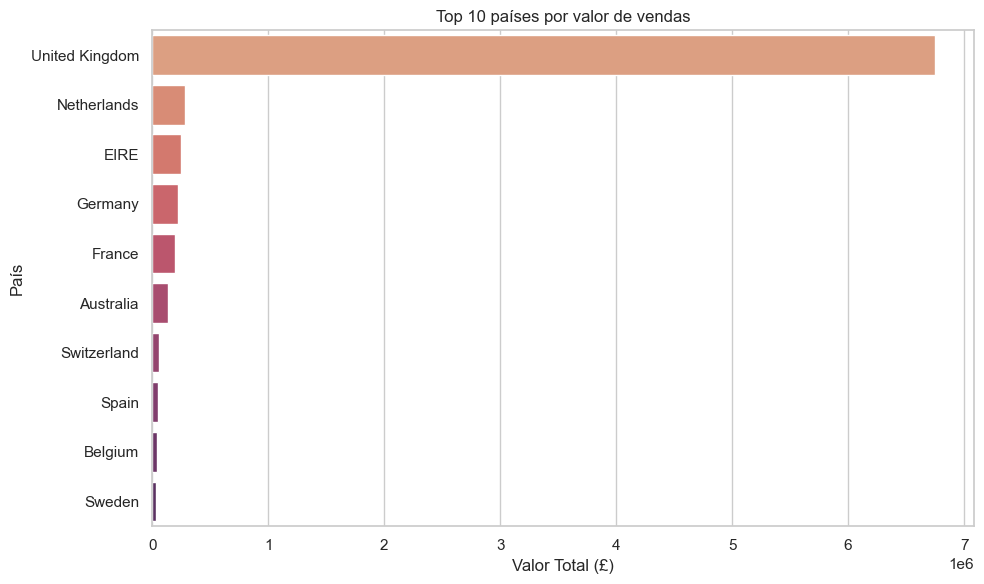

In [39]:
vendas_por_pais = df.groupby("Country")["TotalValue"].sum().sort_values(ascending=False).head(10)
sns.barplot(x=vendas_por_pais.values, y=vendas_por_pais.index, palette="flare")
plt.title("Top 10 países por valor de vendas")
plt.xlabel("Valor Total (£)")
plt.ylabel("País")
plt.tight_layout()
plt.show()

### 4. Distribuição do valor total por pedido

Este gráfico mostra como os valores dos pedidos estão distribuídos, ajudando a identificar padrões, outliers e oportunidades de aumento de ticket.

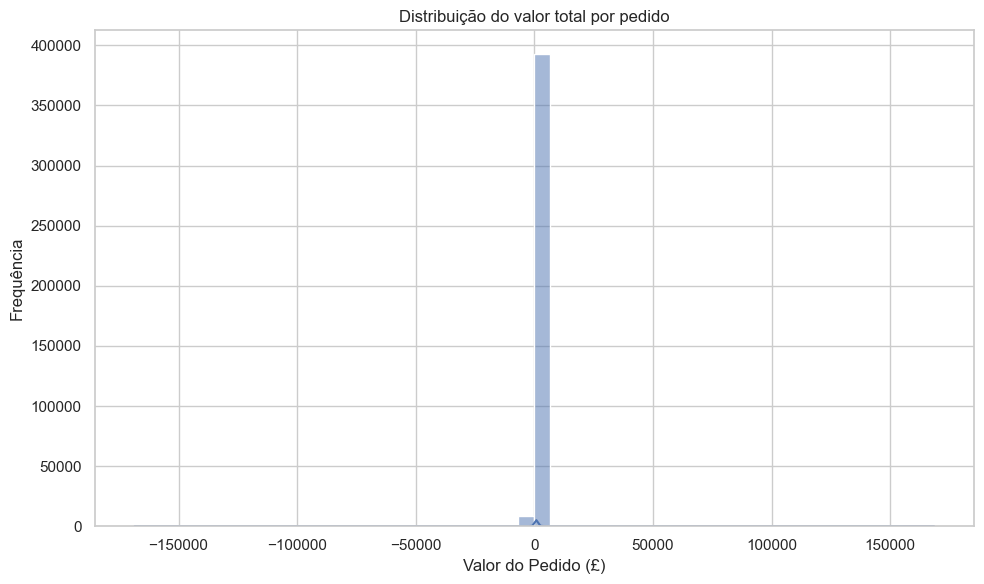

In [40]:
sns.histplot(df["TotalValue"], bins=50, kde=True, color="#4C72B0")
plt.title("Distribuição do valor total por pedido")
plt.xlabel("Valor do Pedido (£)")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

### 5. Vendas mensais

Acompanhar a evolução das vendas ao longo dos meses permite identificar tendências sazonais e períodos de maior faturamento.

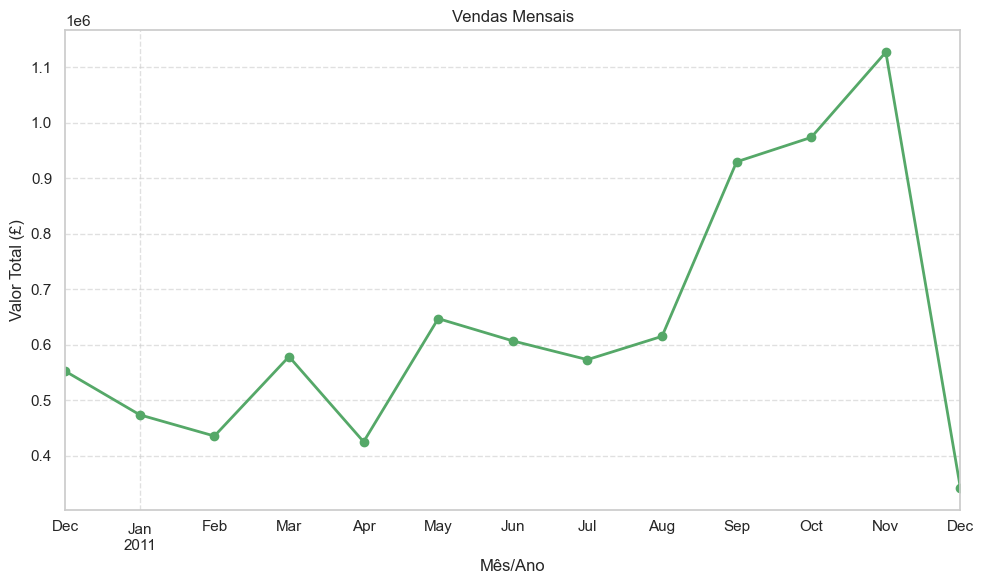

In [41]:
df["MesAno"] = df["InvoiceDate"].dt.to_period("M")
vendas_mensais = df.groupby("MesAno")["TotalValue"].sum()
vendas_mensais.plot(marker="o", color="#55A868", linewidth=2)
plt.title("Vendas Mensais")
plt.xlabel("Mês/Ano")
plt.ylabel("Valor Total (£)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

### 6. Produtos mais lucrativos

Visualizamos os produtos que mais geram receita, não apenas em quantidade, mas em valor financeiro.

C:\Users\Pedro\AppData\Local\Temp\ipykernel_19544\2076070677.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_lucrativos.values, y=top_lucrativos.index, palette="viridis")


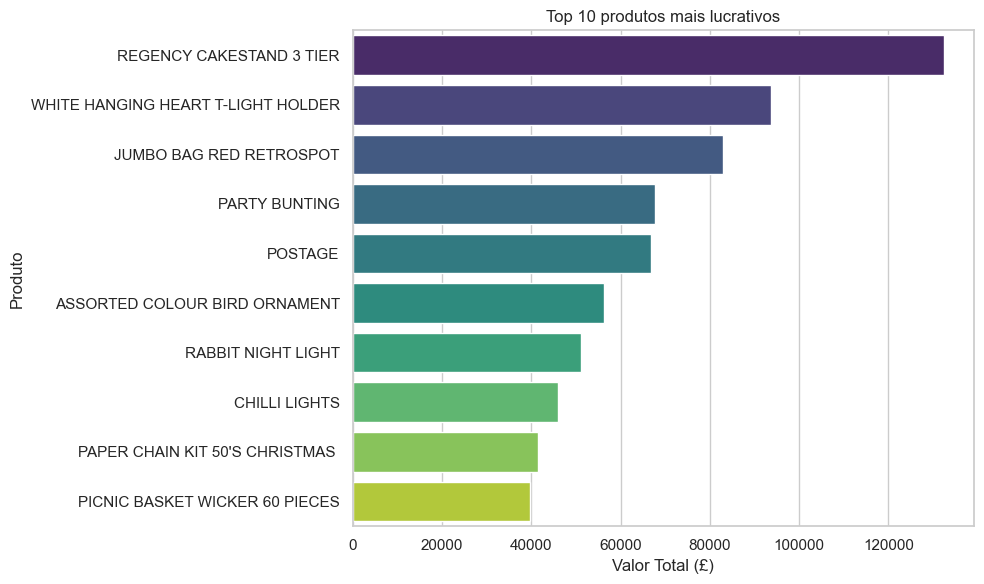

In [42]:
top_lucrativos = df.groupby("Description")["TotalValue"].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_lucrativos.values, y=top_lucrativos.index, palette="viridis")
plt.title("Top 10 produtos mais lucrativos")
plt.xlabel("Valor Total (£)")
plt.ylabel("Produto")
plt.tight_layout()
plt.show()

### 7. Distribuição de vendas por hora do dia

Este gráfico mostra em quais horários do dia ocorrem mais vendas, útil para estratégias de marketing e operação.

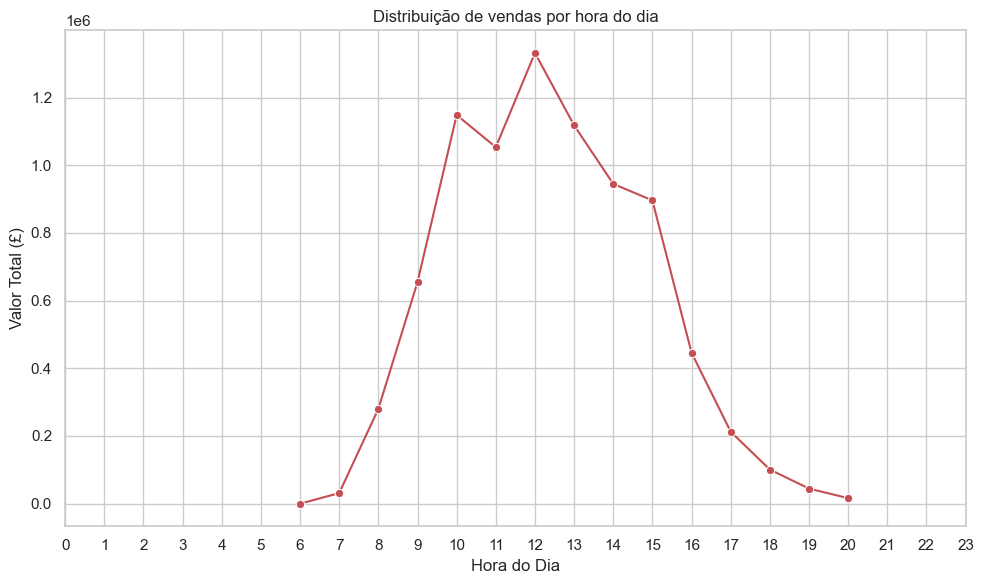

In [43]:
df["Hora"] = df["InvoiceDate"].dt.hour
vendas_por_hora = df.groupby("Hora")["TotalValue"].sum()
sns.lineplot(x=vendas_por_hora.index, y=vendas_por_hora.values, marker="o", color="#C44E52")
plt.title("Distribuição de vendas por hora do dia")
plt.xlabel("Hora do Dia")
plt.ylabel("Valor Total (£)")
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()

### 8. Top 10 países por número de pedidos

Aqui vemos os países com maior quantidade de pedidos, o que pode diferir do ranking por valor.

C:\Users\Pedro\AppData\Local\Temp\ipykernel_19544\2391780817.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pedidos_por_pais.values, y=pedidos_por_pais.index, palette="coolwarm")


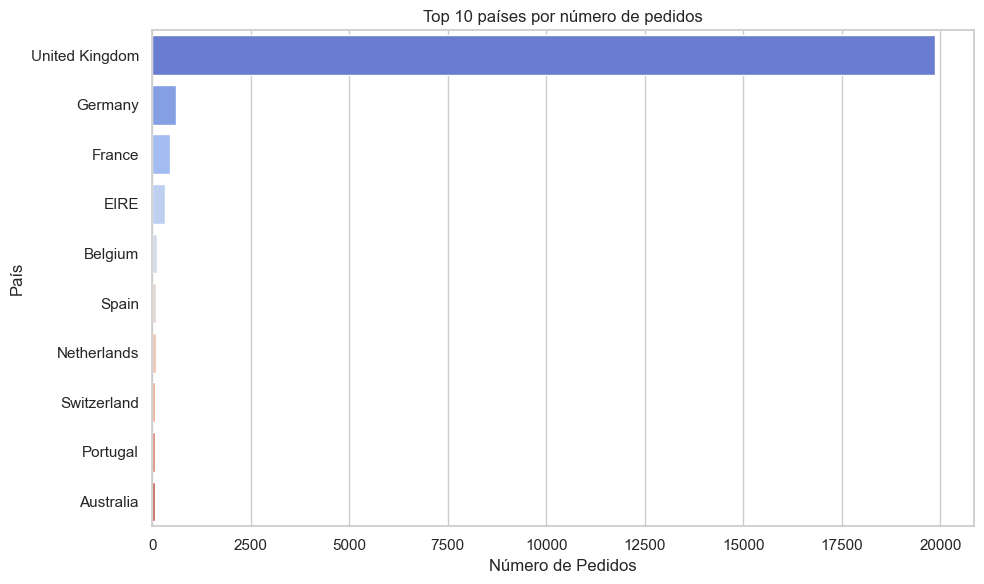

In [44]:
pedidos_por_pais = df.groupby("Country")["InvoiceNo"].nunique().sort_values(ascending=False).head(10)
sns.barplot(x=pedidos_por_pais.values, y=pedidos_por_pais.index, palette="coolwarm")
plt.title("Top 10 países por número de pedidos")
plt.xlabel("Número de Pedidos")
plt.ylabel("País")
plt.tight_layout()
plt.show()